# DYNAMIC FUNCTIONAL CONNECTIVITY (DFC)

In [128]:
import nilearn as nil
import nibabel as nib
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
from nilearn import plotting, surface, datasets, input_data, decomposition
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm # For having progressbar during loops
from nitime.timeseries import TimeSeries
from nitime.analysis import FilterAnalyzer
from sklearn.decomposition import PCA
from nilearn.connectome import ConnectivityMeasure
from matplotlib import colors
from matplotlib import patches
from pycirclize import Circos
import sys
import networkx as nx
import community as community_louvain
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score


## Defining the signal filter function

In [129]:
def signal_filter(nifti_img, mask, standardize=False, ub=0.08, lb=0.008):
    print('Filtering the signal...')
    img = nifti_img.get_fdata()
    img_affine = nifti_img.affine
    TR = nifti_img.header.get_zooms()[3]
    
    n_vox_mask = np.sum(mask==1) # Number of voxels in the mask
    mask_cord = np.where(mask==1)
    img_filtered = np.zeros(img.shape)
#     print(img_filtered.shape)
    for v in tqdm(range(n_vox_mask)):
        voxel_ts = img[mask_cord[0][v], mask_cord[1][v], mask_cord[2][v], :] # time series of the single voxel
        T = TimeSeries(voxel_ts.T, sampling_interval=TR)
        F = FilterAnalyzer(T, ub=0.08, lb=0.008) #0.08, 0.008
        tmp_TC_filt = F.filtered_boxcar.data
        tmp_TC_filt = tmp_TC_filt.T
        if standardize:
            tmp_TC_filt = (tmp_TC_filt-np.mean(tmp_TC_filt))/np.std(tmp_TC_filt)
            
        # Check if there are nan values
        if np.sum(np.isnan(tmp_TC_filt))!=0:
            for t in tmp_TC_filt:
                tmp_TC_filt[t] = 0
        img_filtered[mask_cord[0][v], mask_cord[1][v], mask_cord[2][v], :] = tmp_TC_filt

    return nib.Nifti1Image(img_filtered, img_affine)

## Defining the brain mask and the atlas

In [130]:
# main_path='E:/CorsoFisica/group_mask/' # Path to the folder with the subjects
main_path='/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/functional_connectivity/data-2/group_mask/' # Path to the folder with the subjects
filename='group_mask.nii.gz' # List of the subjects

group_mask_ = nib.load(main_path+filename) # Load the nii.gz file of the subject
group_mask_header = group_mask_.header # Subject's header
group_mask_affine = group_mask_.affine # Subject's affine
group_mask = group_mask_.get_fdata() # Get the numpy version of the nii.gz file
print(group_mask.shape) # x*y*z*time
n_vox_mask = np.sum(group_mask==1) # Number of voxels within the mask

(52, 62, 52)


In [131]:
which_atlas = 'schaefer' # Chose the atlas


if which_atlas=='glasser':
    main_path='/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/functional_connectivity/data-2/atlas/' # Path to the folder with the subjects
    filename = 'glasser_MNI152NLin6Asym_labels_p20_resamp.nii.gz'
    atlas_labels_file = 'glasser_labels.csv'
    delimiter = ','
# We can also try another atlas
elif which_atlas=='schaefer':
    main_path='/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/functional_connectivity/data-2/atlas/' # Path to the folder with the subjects
    filename = 'Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2.4mm_resamp.nii.gz'
    atlas_labels_file = 'Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'
    delimiter = ','


atlas_ = nib.load(main_path+'/'+which_atlas+'/'+filename) # Load the nii.gz file of the subject
atlas_header = atlas_.header # Subject's header
atlas_affine = atlas_.affine # Subject's affine
atlas = atlas_.get_fdata() # Get the numpy version of the nii.gz file
print(atlas.shape) # x*y*z*time

# Labels
atlas_labels = pd.read_csv(main_path+'/'+which_atlas+'/'+atlas_labels_file, delimiter=delimiter)
print(atlas.min(), atlas.max())

atlas_mask = np.zeros(atlas.shape)
atlas_mask[np.where(atlas!=0)] = 1
atlas_mask_ = nib.Nifti1Image(atlas_mask, atlas_affine)

(52, 62, 52)
0.0 200.0


# DFC step 1: define the functional connectivity over sliding windows and concatenate all the subjects

In [132]:
%%time
# We have to chose the length and the stride of the sliding windows
win_size = 8 # number of windows we compare
stride = 2  # stride

# Define the correlation measures
correlation_measure = ConnectivityMeasure(kind='correlation')


main_path = "/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/"


filelist = [f"sub-{i:02d}" for i in range(1,41)]  


# Initialize the variable to store all correlation matrices
corr_matrix_all_sub = np.empty((0, int(atlas.max()), int(atlas.max())))



# Loop over the subjects
for subject_id in filelist:
    file_path = os.path.join(main_path, subject_id, "func", f"concatenated_emotions_{subject_id}", f"{subject_id}_delighted.nii.gz" )

    print(f"Loading: {file_path}")
    
    # Load the subject file
    sub_ = nib.load(file_path)
    
    # Filter the data (assuming `signal_filter` is a defined function)
    sub_filtered_ = signal_filter(sub_, atlas_mask)
    sub_filtered = sub_filtered_.get_fdata()
    
    # Initialize an empty array for parcellized brain data
    sub_parc = np.empty((0, sub_filtered.shape[-1]))  # parcellized brain
    
    # Loop over all brain regions in the atlas
    for a_idx in range(1, int(atlas.max()) + 1):
        area_coord = np.where(atlas == a_idx)  # coordinates of the current brain region
        area_ts = sub_filtered[area_coord].mean(axis=0)  # time series of the current region
        sub_parc = np.concatenate((sub_parc, area_ts[np.newaxis]), axis=0)
    
    # Loop over the entire time series with sliding windows
    t = 0
    while t + win_size < sub_filtered.shape[-1]:
        correlation_matrix = correlation_measure.fit_transform([sub_parc[:, t:t + win_size].T])
        corr_matrix_all_sub = np.concatenate((corr_matrix_all_sub, correlation_matrix), axis=0)
        t += stride
    
    print(corr_matrix_all_sub.shape)


Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-01/func/concatenated_emotions_sub-01/sub-01_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:07<00:00, 3428.00it/s]


(6, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-02/func/concatenated_emotions_sub-02/sub-02_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:07<00:00, 3319.05it/s]


(12, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-03/func/concatenated_emotions_sub-03/sub-03_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:07<00:00, 3242.80it/s]


(18, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-04/func/concatenated_emotions_sub-04/sub-04_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 3681.19it/s]


(24, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-05/func/concatenated_emotions_sub-05/sub-05_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 3601.16it/s]


(30, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-06/func/concatenated_emotions_sub-06/sub-06_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:05<00:00, 4297.64it/s]


(36, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-07/func/concatenated_emotions_sub-07/sub-07_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:05<00:00, 4337.49it/s]


(42, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-08/func/concatenated_emotions_sub-08/sub-08_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 3822.65it/s]


(48, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-09/func/concatenated_emotions_sub-09/sub-09_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 4066.21it/s]


(54, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-10/func/concatenated_emotions_sub-10/sub-10_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 3883.67it/s]


(60, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-11/func/concatenated_emotions_sub-11/sub-11_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 3958.61it/s]


(66, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-12/func/concatenated_emotions_sub-12/sub-12_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 3954.16it/s]


(72, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-13/func/concatenated_emotions_sub-13/sub-13_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 4135.72it/s]


(78, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-14/func/concatenated_emotions_sub-14/sub-14_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 3990.87it/s]


(84, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-15/func/concatenated_emotions_sub-15/sub-15_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 4113.89it/s]


(90, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-16/func/concatenated_emotions_sub-16/sub-16_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 3909.60it/s]


(96, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-17/func/concatenated_emotions_sub-17/sub-17_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 3723.45it/s]


(102, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-18/func/concatenated_emotions_sub-18/sub-18_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:05<00:00, 4335.42it/s]


(108, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-19/func/concatenated_emotions_sub-19/sub-19_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 4004.62it/s]


(114, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-20/func/concatenated_emotions_sub-20/sub-20_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 4165.06it/s]


(120, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-21/func/concatenated_emotions_sub-21/sub-21_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:05<00:00, 4345.24it/s]


(126, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-22/func/concatenated_emotions_sub-22/sub-22_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 4099.52it/s]


(132, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-23/func/concatenated_emotions_sub-23/sub-23_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:07<00:00, 3407.92it/s]


(138, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-24/func/concatenated_emotions_sub-24/sub-24_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 3714.85it/s]


(144, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-25/func/concatenated_emotions_sub-25/sub-25_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 3784.65it/s]


(150, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-26/func/concatenated_emotions_sub-26/sub-26_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:07<00:00, 3422.46it/s]


(156, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-27/func/concatenated_emotions_sub-27/sub-27_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 3937.93it/s]


(162, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-28/func/concatenated_emotions_sub-28/sub-28_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 3841.85it/s]


(168, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-29/func/concatenated_emotions_sub-29/sub-29_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 3710.17it/s]


(174, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-30/func/concatenated_emotions_sub-30/sub-30_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:05<00:00, 4272.31it/s]


(180, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-31/func/concatenated_emotions_sub-31/sub-31_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:05<00:00, 4335.74it/s]


(186, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-32/func/concatenated_emotions_sub-32/sub-32_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 4065.73it/s]


(192, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-33/func/concatenated_emotions_sub-33/sub-33_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 4159.86it/s]


(198, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-34/func/concatenated_emotions_sub-34/sub-34_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:05<00:00, 4342.68it/s]


(204, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-35/func/concatenated_emotions_sub-35/sub-35_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 3754.99it/s]


(210, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-36/func/concatenated_emotions_sub-36/sub-36_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 4019.34it/s]


(216, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-37/func/concatenated_emotions_sub-37/sub-37_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 3711.65it/s]


(222, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-38/func/concatenated_emotions_sub-38/sub-38_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:06<00:00, 3997.53it/s]


(228, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-39/func/concatenated_emotions_sub-39/sub-39_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:08<00:00, 2802.05it/s]


(234, 200, 200)
Loading: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-40/func/concatenated_emotions_sub-40/sub-40_delighted.nii.gz
Filtering the signal...


100%|███████████████████████████████████| 25077/25077 [00:07<00:00, 3221.60it/s]


(240, 200, 200)
CPU times: user 4min 59s, sys: 26 s, total: 5min 25s
Wall time: 4min 46s


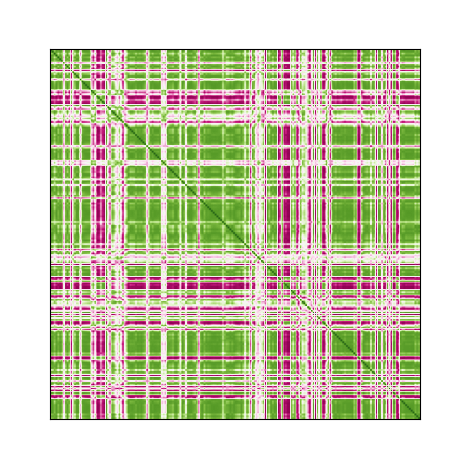

In [158]:
# Plot a few of the connectivity matrix over time for a subject
plt.imshow(corr_matrix_all_sub[100], cmap='PiYG')
plt.xticks([]);
plt.yticks([]);
# plt.savefig('ex_mat_110.png', dpi=300)

# DFC step 2: clusterize each istantaneous connectivity

## Version 1: clusterize the full connectivity matrices
#### chosing a fixed value for the number of cluster

In [134]:
corr_matrix_all_sub.shape

(240, 200, 200)

In [135]:
%%time
# Flatten all the connectivity matrices
corr_matrix_all_sub_flattened = np.reshape(corr_matrix_all_sub, (corr_matrix_all_sub.shape[0], int(atlas.max())*int(atlas.max())))
print(corr_matrix_all_sub_flattened.shape)

# Apply Kmeans
K = 4
kmeans = KMeans(n_clusters=K, random_state=0)  # Specify the number of clusters
kmeans.fit(corr_matrix_all_sub_flattened)

# Get the cluster labels and centers
labels = kmeans.labels_       # Cluster assignments for each matrix

centers = kmeans.cluster_centers_  # Cluster centers in flattened form

print(labels.shape, centers.shape)
centers = np.reshape(centers, (K, int(atlas.max()),int(atlas.max())))
print(centers.shape)


(240, 40000)
(240,) (4, 40000)
(4, 200, 200)
CPU times: user 597 ms, sys: 271 ms, total: 868 ms
Wall time: 625 ms


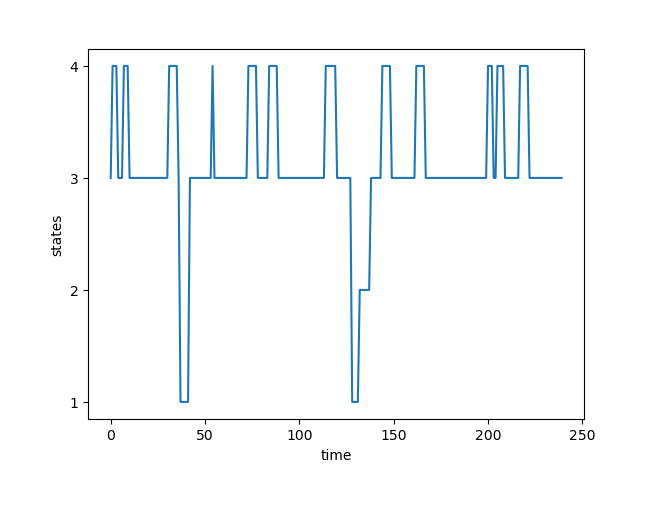

In [136]:
# Plot the dyanmics of the subjects within the set of states
sub_labels = labels[:240]
fig, ax = plt.subplots(1,)
ax.plot(sub_labels, linewidth=1.5)
ax.set_yticks([k for k in range(4)], labels=[k for k in range(1,5)])
ax.set_xlabel('time');
ax.set_ylabel('states');

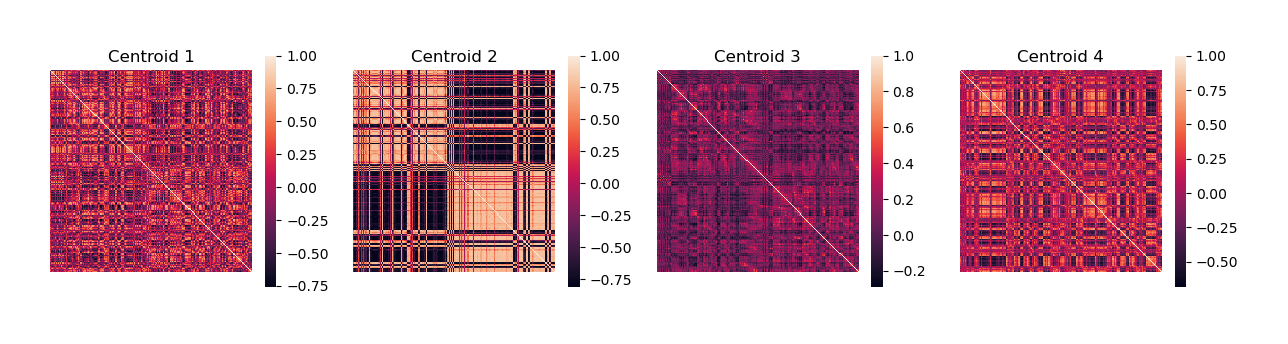

In [137]:
# Plot the centroids
fig, axs = plt.subplots(1,K, figsize=(15, 3))
for i,ax in enumerate(axs.flat):
    sns.heatmap(centers[i], ax=ax, square=True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Centroid '+str(i+1))

## Version 2: clusterize the leading eigenvector of each istantaneous connectivity matrix

In [138]:
# Function to extract leading eigenvectors
def leading_eigenvectors(matrices, n_leading=1):
    leading_eigenvecs = []
    
    for matrix in tqdm(matrices):
        # Step 1: Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(matrix)
        
        # Step 2: Sort eigenvalues in descending order and select the top ones
        idx = np.argsort(eigenvalues)[::-1]  # Indices for sorting eigenvalues in descending order
        leading_vectors = eigenvectors[:, idx[:n_leading]]  # Select top n_leading eigenvectors
        
        #### Change the sign of the leading eigenvector if necessary
        if np.sum(leading_vectors)>0:
            leading_vectors=-leading_vectors;
            #cosa stiamo guardando? staimo estraento i vettori leading da ogni matrice

        ### Show to the students the effect of this trick
        
        leading_eigenvecs.append(leading_vectors)
    
    return leading_eigenvecs

In [139]:
# Extract the leading eigenvpectors from leading connecitivity matrix
n_leading = 1  # Number of leading eigenvectors to extract
eigenvectors = leading_eigenvectors(corr_matrix_all_sub, n_leading)
eigenvectors = [v.real[:,0] for v in eigenvectors]
len(eigenvectors)


100%|█████████████████████████████████████████| 240/240 [00:04<00:00, 57.39it/s]


240

In [140]:

#import numpy as np

#eigenvectors_array = np.array(eigenvectors)  # forma: (100, 90)
#np.savez_compressed("/Users/irenesilvestro/cartella_locale/eigenvectors_static/eigenvectors_excited.npz", data=eigenvectors_array)



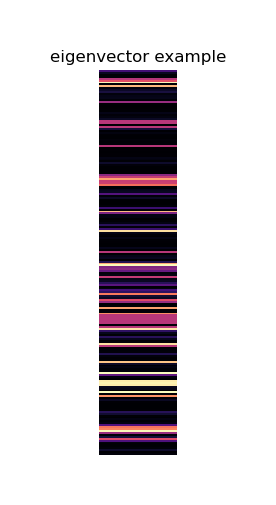

In [141]:
fig = plt.figure(figsize=(1,5))
plt.title('eigenvector example')
sns.heatmap(eigenvectors[10][:,np.newaxis], cbar=False, cmap='magma')
plt.xticks([])
plt.yticks([])
plt.savefig('vector_ex_80', dpi=300)

In [142]:
%%time
# Apply the kmeans to the set of leading eigenvectors
# Apply Kmeans
K = 5
kmeans = KMeans(n_clusters=K, random_state=0)  # Specify the number of clusters
kmeans.fit(eigenvectors)

# Get the cluster labels and centers
labels = kmeans.labels_       # Cluster assignments for each matrix
centers = kmeans.cluster_centers_  # Cluster centers in flattened form
print(labels.shape, centers.shape)


(240,) (5, 200)
CPU times: user 20.2 ms, sys: 12.9 ms, total: 33 ms
Wall time: 10.6 ms


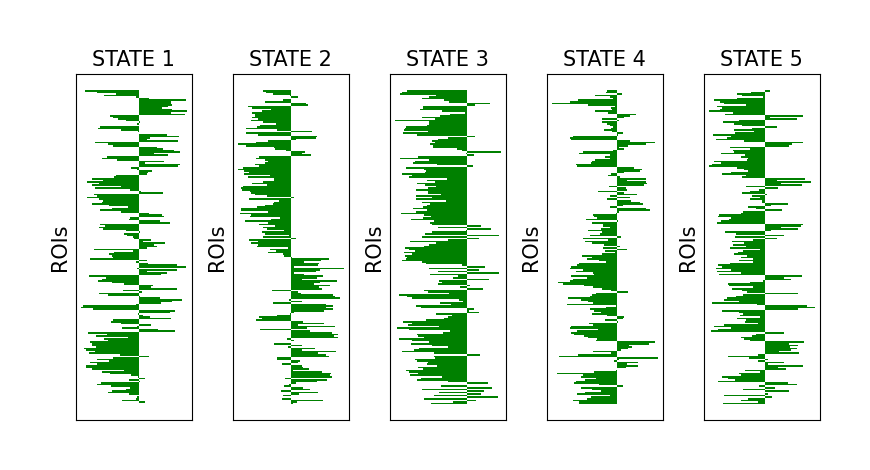

In [143]:
# Plot the eigenvectors
fig, axs = plt.subplots(1, K, figsize=(8,4))
for i,ax in enumerate(axs.flat):
    ax.set_title('STATE {}' .format(i+1), fontsize=15)
    # ax.barh(range(centroids[k_].shape[0]), -centroids[k_], height=1);
    # #              tick_label=nodes_labels)
    ax.barh(range(centers[i].shape[0]), centers[i], height=1, color='green');
    # ax.barh(range(centroids[i].shape[0]), centroids[i], height=1, color='purple');
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel('ROIs', fontsize=15)
    fig.tight_layout() 
    

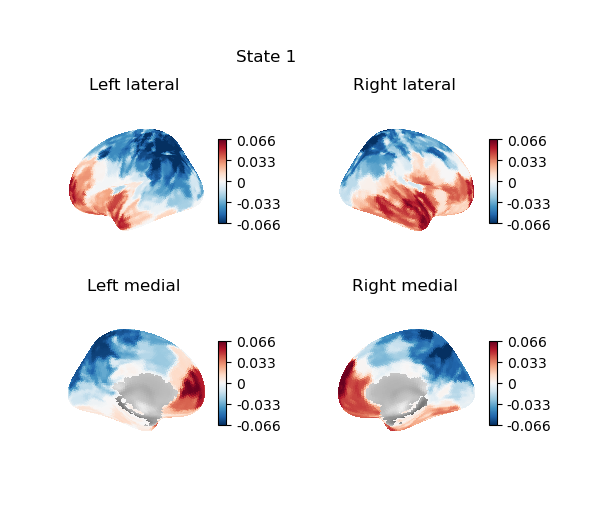

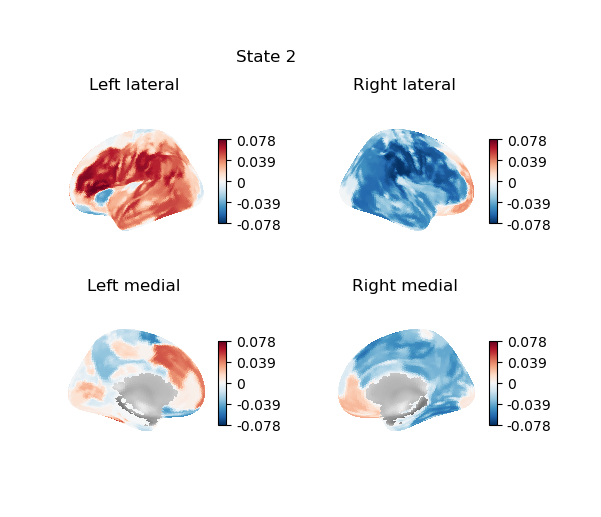

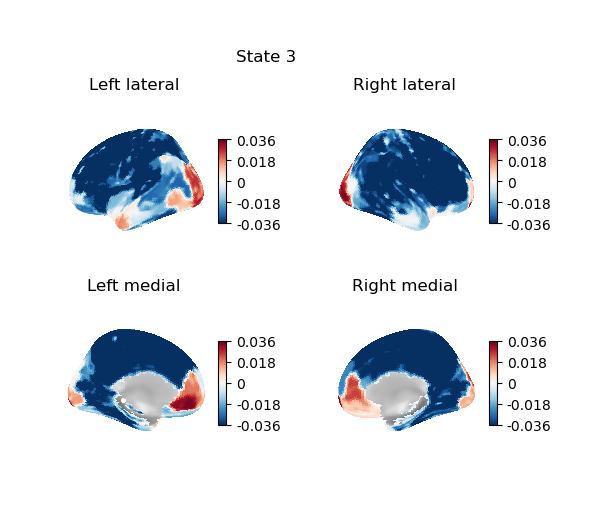

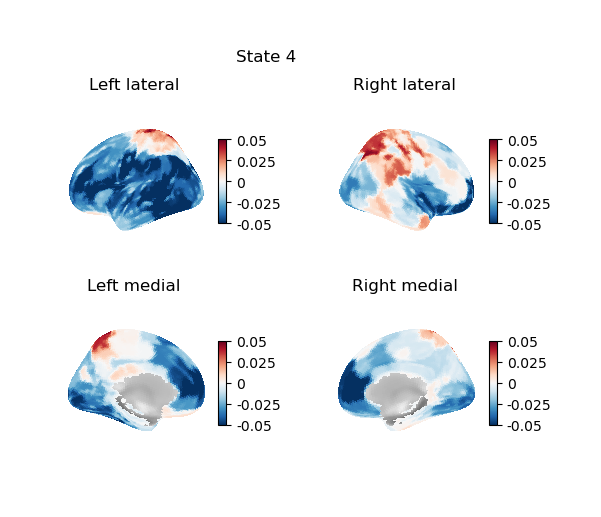

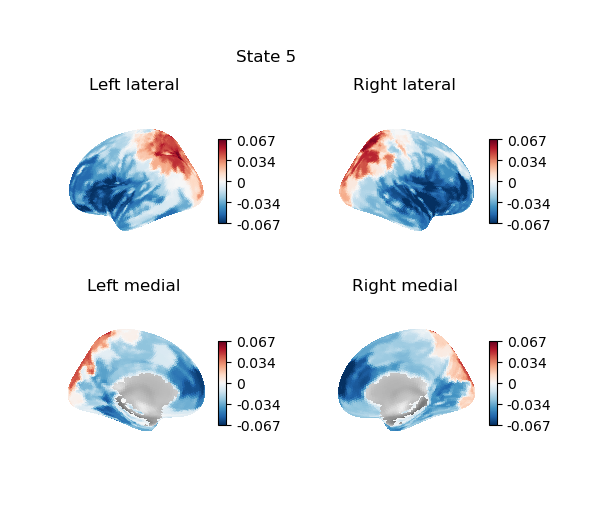

In [144]:
# Plot the centroids over the brain
for c_i,center in enumerate(centers):
    vmin=center.min()
    vmax=center.max()
    brain_centroid = np.zeros((atlas.shape))
    for area_i, area_c in enumerate(center):
        area_coord = np.where(atlas==area_i+1)
        brain_centroid[area_coord[0], area_coord[1], area_coord[2]] = area_c
    nii_img = nib.Nifti1Image(brain_centroid, atlas_affine)
    
    # Plot the betweenness centrality over the brain
    fsaverage = datasets.fetch_surf_fsaverage()
    texture_left = surface.vol_to_surf(nii_img, fsaverage.pial_left)
    texture_left[np.where(texture_left==0)] = np.nan 
    texture_right = surface.vol_to_surf(nii_img, fsaverage.pial_right)
    texture_right[np.where(texture_right==0)] = np.nan 
    
    cmap='RdBu_r'
    fig, axs = plt.subplots(2,2,subplot_kw={'projection': '3d'})
    # left hemisphere
    plotting.plot_surf_stat_map(fsaverage.infl_left, texture_left, bg_map=fsaverage.sulc_left,hemi='left',
                                title='Left lateral', colorbar=True, axes=axs[0][0], cmap=cmap,
                                vmin=-vmax, vmax=vmax)
    plotting.plot_surf_stat_map(fsaverage.infl_left, texture_left, bg_map=fsaverage.sulc_left,hemi='left',
                                title='Left medial', colorbar=True, view='medial', axes=axs[1][0], cmap=cmap,
                                vmin=-vmax, vmax=vmax)
    # Right hemisphere
    plotting.plot_surf_stat_map(fsaverage.infl_right, texture_right, bg_map=fsaverage.sulc_right,hemi='right',
                                title='Right lateral', colorbar=True, view='lateral', axes=axs[0][1], cmap=cmap,
                                vmin=-vmax, vmax=vmax)
    plotting.plot_surf_stat_map(fsaverage.infl_right, texture_right, bg_map=fsaverage.sulc_right,hemi='right',
                                title='Right medial', colorbar=True, view='medial', axes=axs[1][1], cmap=cmap,
                                vmin=-vmax, vmax=vmax)
    plt.suptitle('State '+str(c_i+1))
    
    # Show the plot
    plotting.show()

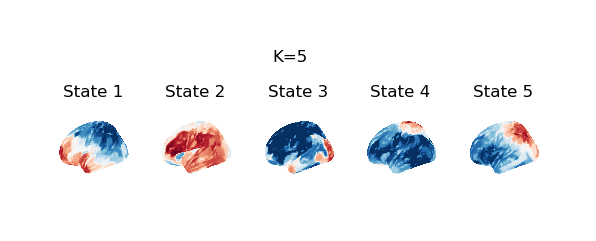

In [145]:
fig, axs = plt.subplots(1,K, subplot_kw={'projection': '3d'})
for c_i, ax in enumerate(axs.flat):
    center = centers[c_i] 
    vmin=center.min()
    vmax=center.max()
    brain_centroid = np.zeros((atlas.shape))
    for area_i, area_c in enumerate(center):
        area_coord = np.where(atlas==area_i+1)
        brain_centroid[area_coord[0], area_coord[1], area_coord[2]] = area_c
    nii_img = nib.Nifti1Image(brain_centroid, atlas_affine)
    
    # Plot the betweenness centrality over the brain
    fsaverage = datasets.fetch_surf_fsaverage()
    texture_left = surface.vol_to_surf(nii_img, fsaverage.pial_left)
    texture_left[np.where(texture_left==0)] = np.nan 

    cmap='RdBu_r'
    # left hemisphere
    plotting.plot_surf_stat_map(fsaverage.infl_left, texture_left, bg_map=fsaverage.sulc_left,hemi='left',
                                title='Left lateral', colorbar=False, view='lateral', axes=ax, cmap=cmap,
                                vmin=-vmax, vmax=vmax)
    ax.set_title('State '+str(c_i+1))
plt.suptitle('K='+str(K),y=0.7);



## Try to find the optimal number of cluster using the silhouette score

In [146]:
%%time
# Loop over a range of posssible values of K
silhouette_scores = []
davis_bouldin_scores = []
for K in range(3, 19):
    kmeans = KMeans(n_clusters=K, random_state=0)  # Specify the number of clusters
    kmeans.fit(eigenvectors)
    
    # Get the cluster labels and centers
    labels = kmeans.labels_       # Cluster assignments for each matrix
    centers = kmeans.cluster_centers_  # Cluster centers in flattened form

    silhouette_scores.append(silhouette_score(eigenvectors, labels))
    davis_bouldin_scores.append(davies_bouldin_score(eigenvectors, labels))

CPU times: user 1.43 s, sys: 296 ms, total: 1.72 s
Wall time: 260 ms


Text(0.5, 0, 'K')

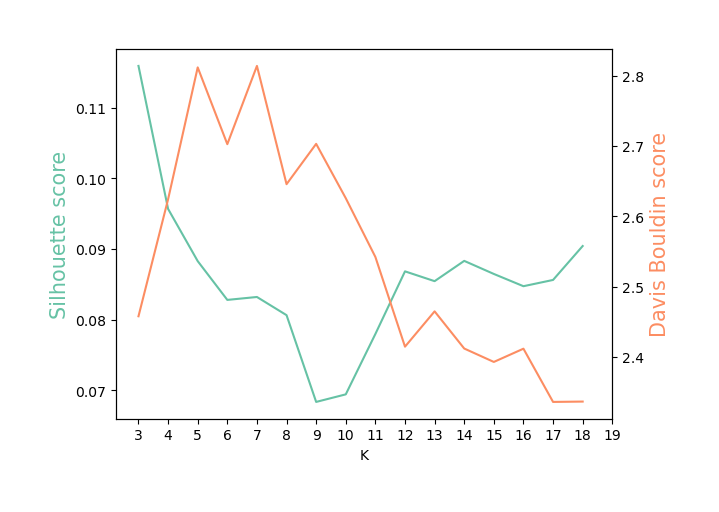

In [147]:
cmap = matplotlib.colormaps['Set2']
colors = cmap(np.linspace(0, 1, 8))
fig, ax = plt.subplots(1,)
ax.plot(silhouette_scores, linewidth=1.5, color=colors[0])
ax2 = ax.twinx()
ax2.plot(davis_bouldin_scores, linewidth=1.5, color=colors[1])
ax.set_xticks([x for x in range(0,20-3)], labels=[x for x in range(3,20)]);
ax.set_ylabel('Silhouette score', color=colors[0], fontsize=15)
ax2.set_ylabel('Davis Bouldin score', color=colors[1], fontsize=15)
ax.set_xlabel('K')

#si capisce quando inizia a fare schifo pensao la partizione 

### Plot the brains associated to the states at different K (to check the robustness of the method)

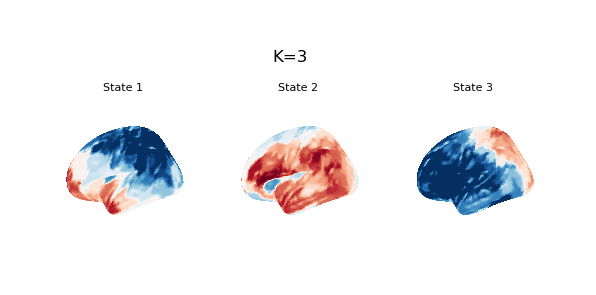

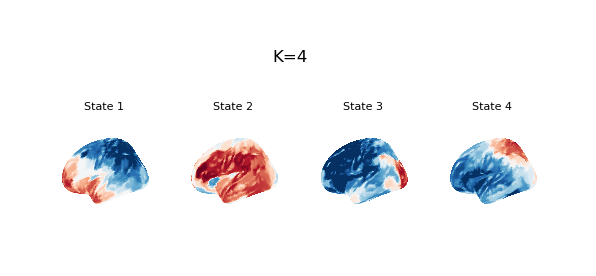

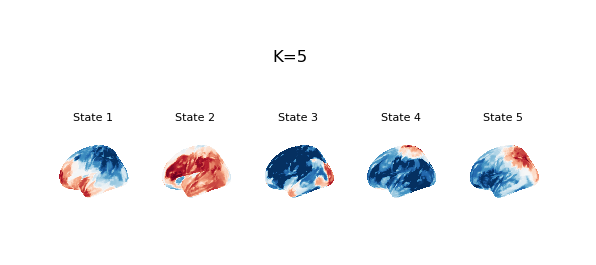

In [148]:
# Loop over a range of posssible values of K
silhouette_scores = []
davis_bouldin_scores = []
for K in range(3, 6):
    kmeans = KMeans(n_clusters=K, random_state=0)  # Specify the number of clusters
    kmeans.fit(eigenvectors)
    
    # Get the cluster labels and centers
    labels = kmeans.labels_       # Cluster assignments for each matrix
    centers = kmeans.cluster_centers_  # Cluster centers in flattened form

    silhouette_scores.append(silhouette_score(eigenvectors, labels))
    davis_bouldin_scores.append(davies_bouldin_score(eigenvectors, labels))
    fig, axs = plt.subplots(1,K, subplot_kw={'projection': '3d'})
    for c_i, ax in enumerate(axs.flat):
        center = centers[c_i] 
        vmin=center.min()
        vmax=center.max()
        brain_centroid = np.zeros((atlas.shape))
        for area_i, area_c in enumerate(center):
            area_coord = np.where(atlas==area_i+1)
            brain_centroid[area_coord[0], area_coord[1], area_coord[2]] = area_c
        nii_img = nib.Nifti1Image(brain_centroid, atlas_affine)
        
        # Plot the betweenness centrality over the brain
        fsaverage = datasets.fetch_surf_fsaverage()
        texture_left = surface.vol_to_surf(nii_img, fsaverage.pial_left)
        texture_left[np.where(texture_left==0)] = np.nan 
    
        cmap='RdBu_r'
        # left hemisphere
        plotting.plot_surf_stat_map(fsaverage.infl_left, texture_left, bg_map=fsaverage.sulc_left,hemi='left',
                                    title='Left lateral', colorbar=False, view='lateral', axes=ax, cmap=cmap,
                                    vmin=-vmax, vmax=vmax)
        ax.set_title('State '+str(c_i+1), fontsize=8)
    plt.suptitle('K='+str(K),y=0.75)
    #capiamo che quello migliore è k=5

In [149]:
#NOW I HAVE TO CHOOSE THE BETTER K 

### Measure the lifetime and the percentage of occurence of each state

ATTENZIONE DA QUI IN POI DEVO RIDEFINIRE IO IL MIGLIOR K!!!!!!!!!

In [150]:
# Apply the kmeans to the set of leading eigenvectors
# Apply Kmeans
K = 4
kmeans = KMeans(n_clusters=K, random_state=0)  # Specify the number of clusters
kmeans.fit(eigenvectors)

# Get the cluster labels and centers
labels = kmeans.labels_       # Cluster assignments for each matrix
centers = kmeans.cluster_centers_  # Cluster centers in flattened form
print(labels.shape, centers.shape)

(240,) (4, 200)


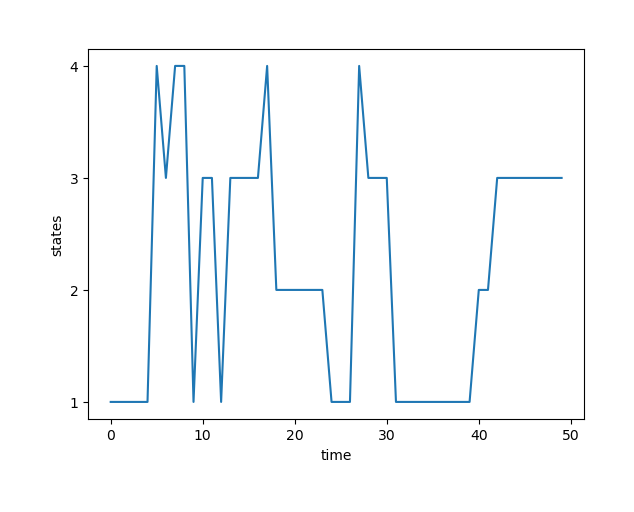

In [151]:
# Plot the dyanmics of the subjects within the set of states
sub_labels = labels[:50]
fig, ax = plt.subplots(1,)
ax.plot(sub_labels, linewidth=1.5)
ax.set_yticks([k for k in range(4)], labels=[k for k in range(1,5)])
ax.set_xlabel('time');
ax.set_ylabel('states');

In [152]:
print(len(eigenvectors))

240


In [153]:
# We want to measure the life time and the percentage of occupancy of each state for each subject, in order to make a statistic

# np.where(ts==s)[0].shape[0]/time_points
n_sub = len(filelist)
time_points = int(len(eigenvectors)/n_sub) # number of sliding windows for each subject

# Percentage of occupancy
PO_dict = {} # Save the results in a dictionary
for k in range(K): # Loop over states
    PO_dict[k] = [] # Initialize the dictionary
    for sub_i in range(n_sub): # Loop over subject
        sub_eigvecs = eigenvectors[sub_i:sub_i+time_points]
        sub_labels = labels[sub_i:sub_i+time_points]

        # Percentage of occupancy of the current state
        count = np.sum(sub_labels==k) # How many time the subject goes in the state k 
        PO = count/time_points
        PO_dict[k].append(PO)

# Lifetime
LT_dict = {} # Save the results in a dictionary
# Initialize LT_dict
for k in range(K):
    LT_dict[k] = []
for sub_i in range(n_sub): # Loop over subject
    sub_eigvecs = eigenvectors[sub_i:sub_i+time_points]
    sub_labels = labels[sub_i:sub_i+time_points]
    
    # Lifetime of the current state
    sub_LT_dict = {} # dict containing length of each segment of each state
    for k in range(K):
        sub_LT_dict[k] = []
    curr_value = sub_labels[0]
    curr_length = 1
    for i in range(len(sub_labels)):
        if sub_labels[i]==curr_value:
            curr_length += 1
        else:
            sub_LT_dict[curr_value].append(curr_length)
            curr_value = sub_labels[i]
            curr_length = 1
    # Save the results for the current subject
    for k in range(K):
        LT_dict[k].append(np.mean(sub_LT_dict[k]))

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


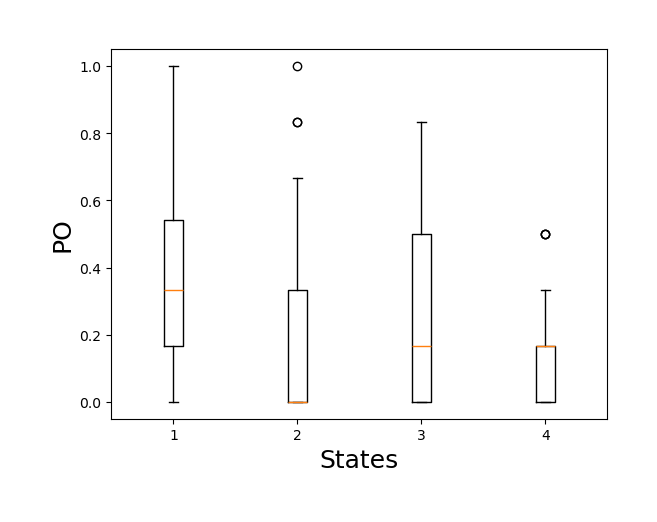

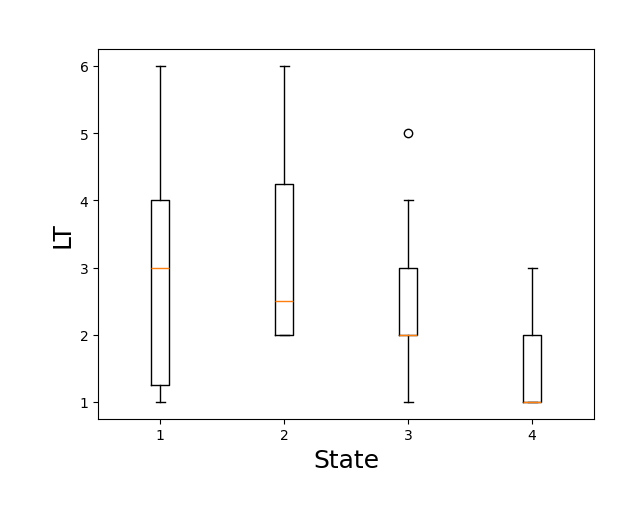

In [154]:
# Plot the lifetime and the percentage of occupancy
# PO
fig, ax = plt.subplots(1,)
for k in PO_dict.keys():
    ax.boxplot(PO_dict[k], positions=[k])
ax.set_xticklabels([i for i in range(1,K+1)])
ax.set_xlabel('States', fontsize=18)
ax.set_ylabel('PO', fontsize=18)

# LT
'''
fig, ax = plt.subplots(1,)
for k in LT_dict.keys():
    ax.boxplot(LT_dict[k], positions=[k])
ax.set_xticklabels([i for i in range(1,K+1)])
ax.set_xlabel('State', fontsize=18);
ax.set_ylabel('LT', fontsize=18);
'''

fig, ax = plt.subplots(1,)
for i, k in enumerate(sorted(LT_dict.keys())):
    cleaned_values = [v for v in LT_dict[k] if not np.isnan(v)]
    if len(cleaned_values) > 0:
        ax.boxplot(cleaned_values, positions=[i+1])
ax.set_xticks(range(1, K+1))
ax.set_xticklabels([i for i in range(1, K+1)])
ax.set_xlabel('State', fontsize=18)
ax.set_ylabel('LT', fontsize=18)
plt.show()



### Transition probability

In [156]:
# Initialize the transition probability matrix
all_sub_trans_prob_matrix = np.zeros((n_sub,K,K))
for sub_i in range(n_sub): # Loop over subject
    sub_eigvecs = eigenvectors[sub_i:sub_i+time_points]
    sub_labels = labels[sub_i:sub_i+time_points]

    prev_value = sub_labels[0]
    for i in range(len(sub_labels)):
        curr_value = sub_labels[i]
        all_sub_trans_prob_matrix[sub_i, prev_value, curr_value] += 1
        prev_value = curr_value
    # Normalize each row for the total number of transition from that state
    for k in range(K):
        total_trans = np.sum(np.sum(all_sub_trans_prob_matrix[sub_i, k, :]))
        if total_trans > 0:
            all_sub_trans_prob_matrix[sub_i, k, :] /= total_trans
        

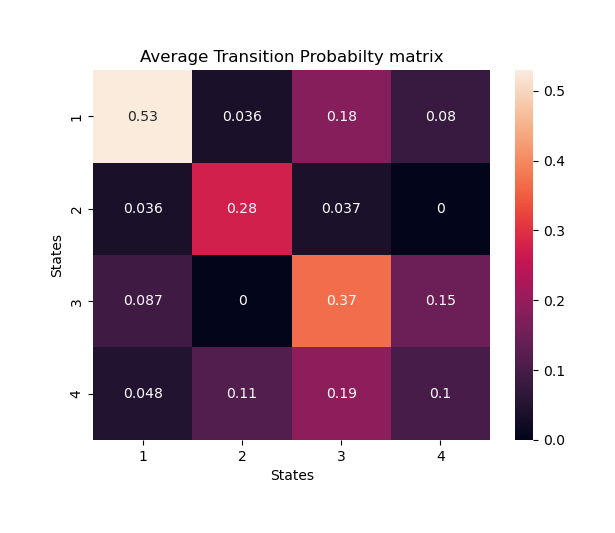

In [157]:
fig, ax = plt.subplots(1,)
sns.heatmap(all_sub_trans_prob_matrix.mean(axis=0), axes=ax, annot=True)
ax.set_xticklabels([i for i in range(1,K+1)]);
ax.set_yticklabels([i for i in range(1,K+1)]);
ax.set_ylabel('States');
ax.set_xlabel('States');
ax.set_title('Average Transition Probabilty matrix');